In [13]:
# Merger rate for IMRIPY system when they throw away all of the dark matter before merging.

import numpy as np
import matplotlib.pyplot as plt
import imripy
from imripy import merger_system as ms
from scipy.interpolate import interp1d
from matplotlib.ticker import FormatStrFormatter
from scipy.optimize import curve_fit
from numpy import diff
   


π = np.pi
G = 4.4959e-15            #in units of M☉^-1 pc^3 yr^-2
c = 0.3068                #in units of pc yr^-1
ρ_eq = 3.1812e3           #in units of M☉ pc^-3 with ρ_eq=2.15368e-16 kg m^-3
pc = 3.0857e16            # in meters
yr = 3.154e7              # in units of seconds
t_eq = 1.59246e12/yr      # in units of seconds
t_m = 13.78e9             #in units of yrs corresponding to t_0=13.78Gyr
t_0 = 13.78e9             #in units of yrs corresponding to t_0=13.78Gyr

σ_eq = 0.005
ρ_m = 4e19                #ρ_m = 4e19 M☉ Gpc^-3



    

            

m_2 = np.geomspace(1e-3, 4, 10)    

m_2_list = m_2.tolist()



m_1 = 30 #in units of solar mass.

print("m_2 =", m_2_list, "M☉")

a_i = 0.01  # in units pf parsec

t_initial_merger_time = t_m





m_2 = [0.001, 0.002513210629792361, 0.006316227669701317, 0.015874010519682003, 0.03989473197550057, 0.10026386447354524, 0.25198420997897486, 0.63328939505899, 1.5915896393970277, 4.0] M☉


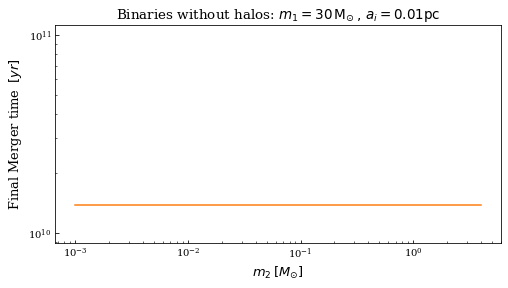

In [2]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'


def final_merger_time_nohalos(m_2):  # assuming a_i = a_f and hence j_i = j_f .
    a_f = a_i
    return (np.sqrt(a_f/a_i)) *t_initial_merger_time



final_merger_time_nohalos_list = np.zeros(len(m_2_list))

for i, m_2 in enumerate(m_2_list):
    final_merger_time_nohalos_list[i] = final_merger_time_nohalos(m_2)
    
    
plt.figure(figsize=(8,4))

plt.loglog(m_2_list, final_merger_time_nohalos_list, 'C1')



plt.xlabel('$m_{2}\:[M_{\odot}]$', fontsize = 13)
plt.ylabel('Final Merger time $\: [yr]$', fontsize = 13)
plt.title('Binaries without halos: $m_{1} = 30 \, \mathrm{M_{\odot}} \,,\, a_{i} = 0.01 \mathrm{pc}$', fontsize = 13.5)
plt.show()     

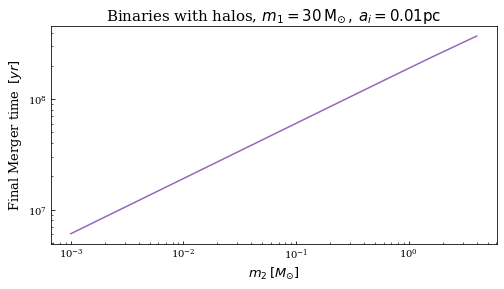

In [3]:

def final_merger_time_withhalos(m_2):  # j_f = sqrt(a_i/a_f) * j_i
    
    
    def x(m_1, m_2):  # Let a_i = (0.0977 * λ *x)
        return  (((3 * (m_1 + m_2 ) * a_i)/(8 * π * ρ_eq))**(1/4)) * ((0.0977)**(-1/4))
    
    def λ(m_1, m_2):
        return (a_i / (0.0977 * x(m_1, m_2)))
    
    
    def s(m_1, m_2): # S_dec of the binary decouple.
        return ((0.03095*λ(m_1, m_2)+ 0.3425)*λ(m_1, m_2))
    
    
    def t_dec(m_1, m_2):    # t_dec of the binary decouple.
        return ((np.sqrt(3/(8*π*G*ρ_eq)))*(((2/3)*(s(m_1, m_2)-2)*np.sqrt(s(m_1, m_2)+1))+(4/3)))
  
    
    def ρ_bar(m):
        return ((ρ_eq/2)*(t_eq**(3/2))*((2*G*m)**(3/4))) 
    
    
    
    def M_1halo(m_1, m_2):
        return (((16*π)/3)*ρ_bar(m_1)*((2*G*m_1*(t_dec(m_1, m_2)**2))**(1/4)))
    
    
    def M_2halo(m_1, m_2):
        return (((16*π)/3)*ρ_bar(m_2)*((2*G*m_2*(t_dec(m_1, m_2)**2))**(1/4)))
    

    def M_binary_initial(m_1, m_2):
        return (m_1 + m_2 + M_1halo(m_1, m_2) + M_2halo(m_1, m_2))
      
    def M_1(m_1, m_2):
        return (m_1 + M_1halo(m_1, m_2))
    
    def M_2(m_1, m_2):
        return (m_2 + M_2halo(m_1, m_2))
    
    def M_binary_final(m_1, m_2):
        return (m_1 + m_2 )
      
    
    #Schwarzchild Radius of the PBH.
    def r_s(m): 
        return ((2*G*m)/(c**2)) 


    #r_turnaround of the dark matter halos, eq.(5) in "WIMPs and stellar-mass primordial black holes are incompatible"
    def r_ta(m): 
        return ((2*G*m*(t_dec(m_1, m_2)**2))**(1/3))


    # The binding energy, E_b of the dark matter halos calculated within r_s and r_ta for dark matter halo's density profile of ρ(r)∝ r^{-9/4}
    def E_b(m): 
        return ((16*π*G*ρ_bar(m)*m*(((r_ta(m))**(-1/4))-((r_s(m))**(-1/4))))-((128/3)*G*(π**2)*(ρ_bar(m)**2)*(((r_ta(m))**(1/2))-((r_s(m))**(1/2)))))
    
    
    def a_final(m_1,m_2):
        return ((G* m_1 * m_2 * a_i)/((G * M_1(m_1, m_2) * M_2(m_1, m_2))-(2 * a_i *(E_b(m_1)+E_b(m_2)))))

    
    
    
    return   (np.sqrt(a_final(m_1, m_2)/a_i)) * t_initial_merger_time



plt.rcParams['font.family'] = 'serif'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'


final_merger_time_withhalos_list = np.zeros(len(m_2_list))

for i, m_2 in enumerate(m_2_list):
    final_merger_time_withhalos_list[i] = final_merger_time_withhalos(m_2)

    
    
plt.figure(figsize=(8, 4))
plt.loglog(m_2_list, final_merger_time_withhalos_list, 'C4')



plt.xlabel('$m_{2}\:[M_{\odot}]$', fontsize = 13)
plt.ylabel('Final Merger time $\: [yr]$', fontsize = 13)
plt.title('Binaries with halos, $m_{1} = 30 \, \mathrm{M_{\odot}} \, , \, a_{i} = 0.01 \mathrm{pc}$', fontsize = 15)
plt.show()     

In [14]:
# Setting initial and final conditions of the binary evolution for an eccentric orbi



e0_list = np.zeros(len(m_2_list))
    
    
for i , m_2 in enumerate(m_2_list):
    def M_binary_initial(m_1, m_2):
        return (m_1 + m_2 )
    def j_initial(m_1, m_2):
        return  (((85/3) * (G**3) * m_1 * m_2 * M_binary_initial(m_1, m_2) * t_m)/((a_i**4)*(c**5)))**(1/7)
    j_i = j_initial(m_1, m_2)
    e0_list[i] = np.sqrt(1 - (j_i**2))
print("e0 =", e0_list)



tm_list = np.zeros(len(m_2_list))
for k, (m_2, e0) in enumerate(zip(m_2_list, e0_list)):
    def t_merger(m_2):
        return (((a_i**4)*(c**5))/((85/3) * (G**3) * m_1 * m_2 * M_binary_initial(m_1, m_2))) * (np.sqrt(1 - e0**2)**7)
    tm_list[k] = t_merger(m_2) 
    
print("t_m =", tm_list, "yr")

e0 = [0.99999948 0.99999932 0.99999911 0.99999885 0.9999985  0.99999805
 0.99999745 0.99999667 0.99999563 0.9999942 ]
t_m = [1.378e+10 1.378e+10 1.378e+10 1.378e+10 1.378e+10 1.378e+10 1.378e+10
 1.378e+10 1.378e+10 1.378e+10] yr


Evolving from  1157407407.4074075  to  1.0 r_isco  with initial eccentricity 0.999999476443502  with  Options: accretion = False, haloPhaseSpaceDescription = False, accuracy = 1.0e-08
The solver successfully reached the end of the integration interval.
 -> Evolution took 0.2023s
Evolving from  1157407407.4074075  to  1.0 r_isco  with initial eccentricity 0.9999993187273447  with  Options: accretion = False, haloPhaseSpaceDescription = False, accuracy = 1.0e-08
The solver successfully reached the end of the integration interval.
 -> Evolution took 0.4653s
Evolving from  1157407407.4074075  to  1.0 r_isco  with initial eccentricity 0.9999991134814231  with  Options: accretion = False, haloPhaseSpaceDescription = False, accuracy = 1.0e-08
A termination event occurred.
 -> Evolution took 4.0836s
Evolving from  1157407407.4074075  to  1.0 r_isco  with initial eccentricity 0.999998846338161  with  Options: accretion = False, haloPhaseSpaceDescription = False, accuracy = 1.0e-08
A termination

/home/pratibhajangra/Desktop/Work/imripy-main/src/imripy/inspiral.py:361: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return -(1.-e**2)**(3./2.)/2./np.pi *np.sqrt(sp.m_total(a) * a*(1.-e**2)) *  quad(integrand, 0., 2.*np.pi, limit = 100)[0]


A termination event occurred.
 -> Evolution took 7.9828s


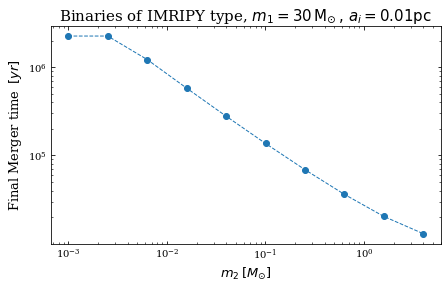

In [15]:
# Setting initial and final conditions of the binary evolution for an eccentric orbi




plt.figure(figsize = (7, 4))
plt.rc('lines', linewidth=1)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.tick_params(which='both', right=True, top=True)






tm_list = np.zeros(len(m_2_list))

for i, m_2 in enumerate(m_2_list):
    
    
    m_bar = m_1
    M_1 =  m_1 * ms.solar_mass_to_pc  
    M_2 =  m_2 * ms.solar_mass_to_pc 
    
    D_luminosity = 5e8              
    ρ_bar = (ρ_eq/2) * (t_eq**(3/2)) * ((2 * G * m_bar)**(3/4))   
    r_spike = 1  # in parsecs, Choosen by choice
    alpha = 9/4
    rho_spike =  ρ_bar * (r_spike**(-alpha)) * ms.solar_mass_to_pc  
    spike = imripy.halo.Spike(rho_spike, r_spike, alpha)
    
    sp = ms.SystemProp(M_1, M_2, spike, D_luminosity)
    a_fin = sp.r_isco()      # Choosen equal to r_icso
    R_fin = sp.r_isco()      # The final condition for the evolution
    
    
    def M_binary_initial(m_1, m_2):
        return (m_1 + m_2 )
      
    def j_initial(m_1, m_2):
        return  (((85/3) * (G**3) * m_1 * m_2 * M_binary_initial(m_1, m_2) * t_m)/((a_i**4)*(c**5)))**(1/7)
    j_i = j_initial(m_1, m_2)
    e0  = np.sqrt(1 - (j_i **2))
    
    
    T =   5e-5 * t_m
    ev_ecc = imripy.inspiral.Classic.Evolve(sp, a_i, e0,  a_fin = R_fin, t_fin = T)
    tm_list[i] = ev_ecc.t[-1]/ms.year_to_pc
    
    
plt.loglog(m_2_list, tm_list, '--o')
    


    

plt.xlabel('$m_{2}\:[M_{\odot}]$', fontsize = 13)
plt.ylabel('Final Merger time $\: [yr]$', fontsize = 13)
plt.title('Binaries of IMRIPY type, $m_{1} = 30 \, \mathrm{M_{\odot}} \, , \, a_{i} = 0.01 \mathrm{pc}$', fontsize = 15)
plt.savefig('t_mimripy.pdf', bbox_inches = 'tight')
plt.show()     

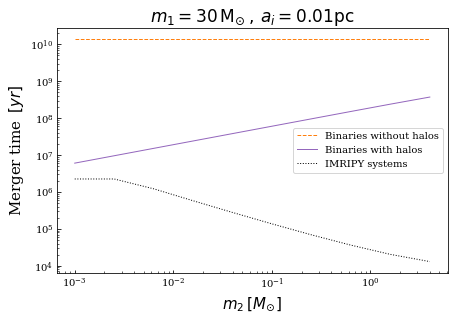

In [16]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.figure(figsize=(7,4.5))


plt.loglog(m_2_list, final_merger_time_nohalos_list, 'C1--')
plt.loglog(m_2_list, final_merger_time_withhalos_list, 'C4')
plt.loglog(m_2_list, tm_list, 'k:')


plt.legend(["Binaries without halos", "Binaries with halos",  "IMRIPY systems"], loc = 'center right')
plt.xlabel('$m_{2}\:[M_{\odot}]$', fontsize = 15)
plt.ylabel('Merger time $\: [yr]$', fontsize = 15)
plt.title('$m_{1} = 30 \, \mathrm{M_{\odot}} \: , \,  a_{i} = 0.01 \mathrm{pc}$', fontsize = 17)
plt.savefig('mergertime.pdf', bbox_inches = 'tight')
plt.show()  